# Interactive Session: Human Population Data - US Census

![ntl](./assets/humans.jpg)

Humans create [complex systems](https://en.wikipedia.org/wiki/Complex_system) and, as such, humans are incredibly difficult to study. Even counting how many people there on the planet is difficult. Many large countries - which we think have rapidly growing populations - have not had a [reliable census conducted in decades](https://www.pnas.org/doi/abs/10.1073/pnas.1715305115). Even the United States, which has a well-regarded and well-funded census, has trouble [estimating population](https://doi.org/10.1016/j.apgeog.2013.11.002). 

Human population data is very powerful. In the US, **Trillions of dollars** are distributed based on Census data. That's a lot of money. Human population data can and has been used for effecting humanitarian aid, stuyding population exposure to environmental contaminants, and for political reasons such as re-districting or gerry-mandering. Human population data can be used for evaluating human exposure to wildfire smoke, or evaluating potential impacts of hurricanes, among other things. The power of This is all to say, that while human data is really important for sustainability, there are true ethical considerations when developing and using human datasets.

In this session, we will become familiar with a few human population datasets, specifically the US Census. In doing so, we will learn about [application programming interfaces (APIs)](https://en.wikipedia.org/wiki/API).

<p style="height:1pt"> </p>

<div class="boxhead2">
    Session Topics
</div>

<div class="boxtext2">
<ul class="a">
    <li> 📌 Introduction to <span class="codeb">US Census Data</span> </li>
    <ul class="b">
        <li> Census API </li>
        <li> Merging with shapefiles </li>
        <li> Plotting Data </li>
        <li> Area Aggregation </li>
    </ul>
</div>

<hr style="border-top: 0.2px solid gray; margin-top: 12pt; margin-bottom: 0pt"></hr>

### Instructions
We will work through this notebook together. To run a cell, click on the cell and press "Shift" + "Enter" or click the "Run" button in the toolbar at the top. 

<p style="color:#408000; font-weight: bold"> 🐍 &nbsp; &nbsp; This symbol designates an important note about Python structure, syntax, or another quirk.  </p>

<p style="color:#008C96; font-weight: bold"> ▶️ &nbsp; &nbsp; This symbol designates a cell with code to be run.  </p>

<p style="color:#008C96; font-weight: bold"> ✏️ &nbsp; &nbsp; This symbol designates a partially coded cell with an example.  </p>

<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

# US Census Data

<img src="./assets/income-censustract.jpg">

The US Census Bureau's "mission is to serve as the nation's leading provider of quality data about its people and economy." It collects, curates and disseminates a wide range of demographic and economic data. It's mission in enshrined the US constitution. 

The [Decadal Populationa and Housing Census](https://www.census.gov/programs-surveys/decennial-census.html#:~:text=The%20U.S.%20census%20counts%20each,of%20Representatives%20among%20the%20states.) is designed to be a complete count of people residents of the United States' territory, whereas the [American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs) is conducted annually has uses a spatiall-informed sampling strategy to estimate demographic data for the entire country. Both surveys are quite useful.

With the Census, it's important to remember that how we group people changes overtime. For example, how we count Hispanic-indentifying residents of the US has [changes through time](https://en.wikipedia.org/wiki/Race_and_ethnicity_in_the_United_States_census), just as various other racial and ethnic groups. This makes tracking specific demographics through time quite difficult. Similiarly, census boundaries can change through time - again making it difficult to measure fine-grained demographic change overtime. But the Census makes a strong effort to document changes and inform users how demographic data is collected and aggregated over space and time. 

Take a moment to checkout the [graphic below](https://www2.census.gov/geo/pdfs/reference/geodiagram.pdf). 

<img src="./assets/cenus-spatial.png">

It's useful to familiarize yourself with the various spatial domains available from the Census. While it is quite easy to download US Census data, let's use the [Python Census API](https://pygis.io/docs/d_access_census.html) to check out US Census data right in our notebook. Note that this tutorial borrows from a great online resource: [PyGIS - Open Source Spatial Programming & Remote Sensing](https://pygis.io/docs/a_intro.html). Check it out!

### Importing Data from the Census API
<hr style="border-top: 0.2px solid gray; margin-top: 12px; margin-bottom: 1px"></hr>

Some APIs are fully public, some require free credentials (e.g. a way to authentic users), and some require a fee to use them. <br>

Please obtain a census API Key here: https://api.census.gov/data/key_signup.html <br> 

Note: I had trouble getting a key and I had to try several times with different email address to finally have one work. We are going to try to use my Census API Key (see below).

The Census API allows us to read in census data into memory. The Census, like many organizations, uses a common, yet complex, naming convention for variables. Some variables make sense (e.g. `NAME`) and others are alpha numeric. You can checkout the [US Census API User Guide](https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf). For geographic information, the Census uses [FIPS](https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code) codes, which are a standardize format to identify geographic adminstrative areas in the US.  

Here we are going to use the [ACS5](https://www.census.gov/data/developers/data-sets/acs-5year.html). From this we'll pull some demographic and socioeconomic data for the great state of Montana.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [12]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import rasterio
import sys

In [13]:
# Set API key 
#c = Census('c2b7b1b0ee04a89666fd161e16d3e1dcec53d1b9') # My key ... please switch to your key.
c = Census('a2f8294507c98bb7618707b52a63763b8c6ba988')
c

Here are the variables we're going to pull from the API:
1. C17002_001E - Ratio of Income to Poverty Level in the Past 12 Months Total (e.g. total number of people in 'poverty')
1. C17002_002E - Ratio of Income to Poverty Level in the Past 12 Months <50% (e.g. 50% of poverty line)
1. C17002_003E - Ratio of Income to Poverty Level in the Past 12 Months 50-99% (e.g. 50% of poverty line)
1. B01003_001E - Total Population

You can check out the variables yourself [here](https://api.census.gov/data/2022/acs/acs5/variables.html). 

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [14]:
# Make the API request
mt_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.MT.fips, # You can change the state here
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2021)  # You can change the year here

In [15]:
# Create a dataframe from the census data
mt_df = pd.DataFrame(mt_census)

# Show the dataframe
mt_df.head(2)
mt_df

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract
0,"Census Tract 1, Beaverhead County, Montana",1510.0,52.0,96.0,1510.0,30,001,000100
1,"Census Tract 2, Beaverhead County, Montana",3749.0,30.0,449.0,3757.0,30,001,000200
2,"Census Tract 3, Beaverhead County, Montana",3636.0,411.0,428.0,4124.0,30,001,000300
3,"Census Tract 1, Big Horn County, Montana",4432.0,181.0,749.0,4503.0,30,003,000100
4,"Census Tract 9404, Big Horn County, Montana",1656.0,397.0,218.0,1745.0,30,003,940400
...,...,...,...,...,...,...,...,...
314,"Census Tract 18.06, Yellowstone County, Montana",1934.0,54.0,61.0,1993.0,30,111,001806
315,"Census Tract 19.01, Yellowstone County, Montana",4679.0,80.0,293.0,4843.0,30,111,001901
316,"Census Tract 19.02, Yellowstone County, Montana",4911.0,152.0,166.0,4911.0,30,111,001902
317,"Census Tract 9400.01, Yellowstone County, Montana",5002.0,425.0,259.0,5053.0,30,111,940001


In [16]:
# Check out the shape

In [17]:
# Check out the data type

### Adding geography
<hr style="border-top: 0.2px solid gray; margin-top: 12px; margin-bottom: 1px"></hr>

Notice that the census data does not have any geographic information ascribed to it. We'll need to read in data directly from the Census's database of boundaries. `GeoPandas` can do this directly from the internet if the data is set up correctly. <br>

Note that I had to dive into the the [Census Tiger Product Guide](https://www.census.gov/programs-surveys/geography/guidance/tiger-data-products-guide.html) to make sense of the Census shapefiles that are online, again because they use a alphanumeric coding, not common place names.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [18]:
# Access shapefile of Montana census tracts
mt_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_30_tract.zip")
mt_tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,30,029,000101,30029000101,1400000US30029000101,1.01,Census Tract 1.01,G5020,S,4688689678,89374843,+48.6403613,-114.1929769,"POLYGON ((-114.88873 48.60095, -114.88872 48.6..."
1,30,029,001101,30029001101,1400000US30029001101,11.01,Census Tract 11.01,G5020,S,1832500,6562,+48.1920787,-114.3261339,"POLYGON ((-114.33997 48.19705, -114.33982 48.1..."
2,30,029,001703,30029001703,1400000US30029001703,17.03,Census Tract 17.03,G5020,S,1813479759,24064760,+48.1102299,-114.7392721,"POLYGON ((-115.02012 48.19747, -115.0201 48.19..."
3,30,029,000903,30029000903,1400000US30029000903,9.03,Census Tract 9.03,G5020,S,3846857,48688,+48.2116106,-114.3184051,"POLYGON ((-114.33061 48.22098, -114.33057 48.2..."
4,30,029,000802,30029000802,1400000US30029000802,8.02,Census Tract 8.02,G5020,S,58392970,1352592,+48.1793434,-114.3555488,"POLYGON ((-114.39825 48.17564, -114.39824 48.1..."


In [19]:
# What crs is the tract in?
mt_tract.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [20]:
# What size in the tract file?
mt_tract.size

4466

In [21]:
# What are the data types of each column?
mt_tract.dtypes

STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [22]:
# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
#mt_tract = mt_tract.to_crs(epsg = 32617)
mt_tract = mt_tract.to_crs(epsg = 6515) #Updated montana-only coordinate system
print(mt_tract.crs)
mt_tract.head()

EPSG:6515


,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,30,029,000101,30029000101,1400000US30029000101,1.01,Census Tract 1.01,G5020,S,4688689678,89374843,+48.6403613,-114.1929769,"POLYGON ((665871.257 1631099.823, 665913.452 1..."
1,30,029,001101,30029001101,1400000US30029001101,11.01,Census Tract 11.01,G5020,S,1832500,6562,+48.1920787,-114.3261339,"POLYGON ((789249.696 1475413.46, 789286.322 14..."
2,30,029,001703,30029001703,1400000US30029001703,17.03,Census Tract 17.03,G5020,S,1813479759,24064760,+48.1102299,-114.7392721,"POLYGON ((623799.05 1486524.195, 623844.046 14..."
3,30,029,000903,30029000903,1400000US30029000903,9.03,Census Tract 9.03,G5020,S,3846857,48688,+48.2116106,-114.3184051,"POLYGON ((792066.248 1483983.652, 792104.033 1..."
4,30,029,000802,30029000802,1400000US30029000802,8.02,Census Tract 8.02,G5020,S,58392970,1352592,+48.1793434,-114.3555488,"POLYGON ((774579.255 1468502.942, 774584.767 1..."


#### GEOID
Notice that the `mt_tract` has a `GEOID` column but `mt_df` does not. So we need to combine the FIPS columns into a single GEOID that we can use to merge onto the shape file. This is pretty easy with simple string addition. 

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [23]:
# Combine state, county, and tract columns together to create a new string and assign to new column
mt_df["GEOID"] = mt_df["state"] + mt_df["county"] + mt_df["tract"]

In [24]:
# Print head of dataframe
mt_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 1, Beaverhead County, Montana",1510.0,52.0,96.0,1510.0,30,001,000100,30001000100
1,"Census Tract 2, Beaverhead County, Montana",3749.0,30.0,449.0,3757.0,30,001,000200,30001000200


In [25]:
# Remove columns we won't need later
mt_df = mt_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
mt_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 1, Beaverhead County, Montana",1510.0,52.0,96.0,1510.0,30001000100
1,"Census Tract 2, Beaverhead County, Montana",3749.0,30.0,449.0,3757.0,30001000200


#### Check the data types
It's always good to check the data types before you merge two DataFrames to make sure that they will merge correctly.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [26]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(mt_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(mt_tract.dtypes))

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


Now merge the two DataFrames

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [27]:
# Join the attributes of the dataframes together
mt_merge = mt_tract.merge(mt_df, on = "GEOID")
mt_merge.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,C17002_001E,C17002_002E,C17002_003E,B01003_001E
0,30,029,000101,30029000101,1400000US30029000101,1.01,Census Tract 1.01,G5020,S,4688689678,89374843,+48.6403613,-114.1929769,"POLYGON ((665871.257 1631099.823, 665913.452 1...","Census Tract 1.01, Flathead County, Montana",821.0,61.0,106.0,860.0
1,30,029,001101,30029001101,1400000US30029001101,11.01,Census Tract 11.01,G5020,S,1832500,6562,+48.1920787,-114.3261339,"POLYGON ((789249.696 1475413.46, 789286.322 14...","Census Tract 11.01, Flathead County, Montana",3165.0,118.0,133.0,3165.0
2,30,029,001703,30029001703,1400000US30029001703,17.03,Census Tract 17.03,G5020,S,1813479759,24064760,+48.1102299,-114.7392721,"POLYGON ((623799.05 1486524.195, 623844.046 14...","Census Tract 17.03, Flathead County, Montana",2115.0,81.0,236.0,2160.0
3,30,029,000903,30029000903,1400000US30029000903,9.03,Census Tract 9.03,G5020,S,3846857,48688,+48.2116106,-114.3184051,"POLYGON ((792066.248 1483983.652, 792104.033 1...","Census Tract 9.03, Flathead County, Montana",3161.0,278.0,213.0,3315.0
4,30,029,000802,30029000802,1400000US30029000802,8.02,Census Tract 8.02,G5020,S,58392970,1352592,+48.1793434,-114.3555488,"POLYGON ((774579.255 1468502.942, 774584.767 1...","Census Tract 8.02, Flathead County, Montana",6203.0,85.0,326.0,6203.0


In [28]:
# What data types are the columns?
mt_merge.dtypes

STATEFP          object
COUNTYFP         object
TRACTCE          object
GEOID            object
GEOIDFQ          object
NAME_x           object
NAMELSAD         object
MTFCC            object
FUNCSTAT         object
ALAND             int64
AWATER            int64
INTPTLAT         object
INTPTLON         object
geometry       geometry
NAME_y           object
C17002_001E     float64
C17002_002E     float64
C17002_003E     float64
B01003_001E     float64
dtype: object

#### Poverty Rates
Now let's select a few columns to make our DateFrame easier to manage. Notice that we are using `.copy()` and since pd.DataFrame.copy() produces a **deep copy by default** we have a new object in memory and Python will not throw runtime warnings.

To estimate poverty rates, we need to take the poverty ratios and divide them by the total number of people in each census tract.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [29]:
# Create new dataframe from select columns
mt_poverty_tract = mt_merge[["STATEFP", "COUNTYFP", "TRACTCE", 
                             "GEOID", "geometry", "C17002_001E", 
                             "C17002_002E", "C17002_003E", "B01003_001E"]].copy()
mt_poverty_tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E
0,30,029,000101,30029000101,"POLYGON ((665871.257 1631099.823, 665913.452 1...",821.0,61.0,106.0,860.0
1,30,029,001101,30029001101,"POLYGON ((789249.696 1475413.46, 789286.322 14...",3165.0,118.0,133.0,3165.0
2,30,029,001703,30029001703,"POLYGON ((623799.05 1486524.195, 623844.046 14...",2115.0,81.0,236.0,2160.0
3,30,029,000903,30029000903,"POLYGON ((792066.248 1483983.652, 792104.033 1...",3161.0,278.0,213.0,3315.0
4,30,029,000802,30029000802,"POLYGON ((774579.255 1468502.942, 774584.767 1...",6203.0,85.0,326.0,6203.0


In [30]:
# Get poverty rate and store in new column
mt_poverty_tract["Poverty_Rate"] = (mt_poverty_tract["C17002_002E"] 
                                     + mt_poverty_tract["C17002_003E"]) / mt_poverty_tract["B01003_001E"] * 100

#### Now plot the data:

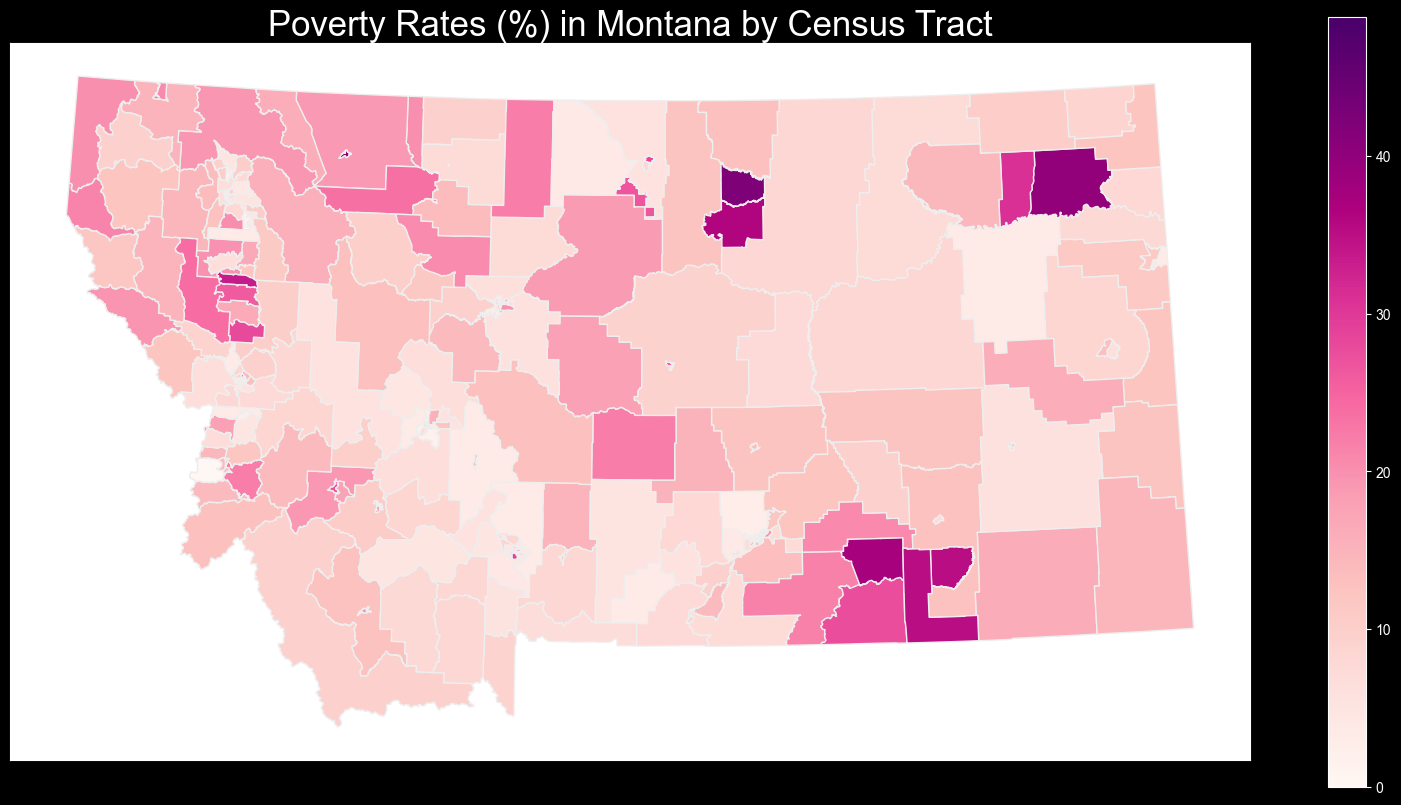

In [31]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
mt_poverty_tract.plot(column = 'Poverty_Rate', ax = ax, cmap = 'RdPu', legend=True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Montana by Census Tract', fontdict = {'fontsize': '25', 'fontweight' : '3'})

# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Set background color
ax.set_facecolor('white')

# show the plot
plt.show()

### Spatial Aggregation
<hr style="border-top: 0.2px solid gray; margin-top: 12px; margin-bottom: 1px"></hr>

We may want to aggregate data to the county level. This is very easy to do with `GeoPandas` and uses a spatial [`dissolve`](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html) methods just like ArcGIS or QGIS. In short, `dissolve` uses categorical data to dissolve the boundaries between ajoining polygons with the same catagorical value. In this case, we will use the `COUNTYFP` code to dissolve the census tract level data. We will need to pass an aggregation method (see [here](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html). In this case, we'll use `sum`.

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [32]:
# Dissolve data
mt_poverty_tract_d = mt_merge[["STATEFP", "COUNTYFP", "TRACTCE", 
                             "GEOID", "geometry", "C17002_001E", 
                             "C17002_002E", "C17002_003E", "B01003_001E"]].copy()
mt_poverty_county = mt_poverty_tract_d .dissolve(by = 'COUNTYFP', aggfunc = 'sum')
mt_poverty_county.head(2)

,geometry,STATEFP,TRACTCE,GEOID,C17002_001E,C17002_002E,C17002_003E,B01003_001E
COUNTYFP,,,,,,,,
001,"POLYGON ((835512.673 559594.448, 835570.54 559...",303030,000300000100000200,300010003003000100010030001000200,8895.0,493.0,973.0,9391.0
003,"POLYGON ((2611811.26 282410.663, 2609951.212 2...",3030303030,940500000100940700940600940400,3000394050030003000100300039407003000394060030...,12952.0,1453.0,2247.0,13198.0


In [33]:
# Use the dataframe's shape to see how many counties there are in Montana
mt_poverty_county.shape

(56, 8)

In [34]:
# Get poverty rate and store in new column
mt_poverty_county["Poverty_Rate"] = (mt_poverty_county["C17002_002E"] + 
                                     mt_poverty_county["C17002_003E"]) / mt_poverty_county["B01003_001E"] * 100

# Show dataframe
mt_poverty_county.head(2)

,geometry,STATEFP,TRACTCE,GEOID,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,,,,
001,"POLYGON ((835512.673 559594.448, 835570.54 559...",303030,000300000100000200,300010003003000100010030001000200,8895.0,493.0,973.0,9391.0,15.610691
003,"POLYGON ((2611811.26 282410.663, 2609951.212 2...",3030303030,940500000100940700940600940400,3000394050030003000100300039407003000394060030...,12952.0,1453.0,2247.0,13198.0,28.034551


In [ ]:
# Create subplots
from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots(1, 1, figsize = (20, 10)) #Mess with fig size as desired til it looks good


# Plot data
mt_poverty_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "PiYG", #PiYG, #RdPu
                       edgecolor='black',       # Outline color
                       linewidth=1.0,
                       legend = True,
                       legend_kwds={
                        'label': "Poverty Rate (%)",
                        'orientation': "vertical"
},)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Montana by County', fontdict = {'fontsize': '25', 'fontweight' : '3'})

# Hide grid lines
ax.grid(False)

#Add a geographic scalebar
scalebar = ScaleBar(1, units="m", location='lower right', length_fraction=0.20, box_color ='black', color='white',
                     font_properties={'size': 14})
ax.add_artist(scalebar)

#Remove the outline around the plot
for spine in ax.spines.values():
    spine.set_visible(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Set background color
#ax.set_facecolor('white')
ax.set_facecolor('black')

# show the plot
#ax.set_axis_off()
plt.show()